### 🔧 SECTION 1: SETUP & PARAMETERS (Synthetic Simulation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Physical constants
sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)

# Material & environment parameters
params = {
    "k": 205,        # W/m·K (aluminum)
    "rho": 2700,     # kg/m³
    "cp": 900,       # J/kg·K
    "t": 0.005,      # m (plate thickness)
    "G_t": 800,      # W/m² (solar input)
    "T_ambient": 298,# K
    "h": 10,         # Convective coeff
    "epsilon": 0.9,  # Emissivity
    "L": 1.0,        # Plate length (m)
    "W": 0.5,        # Plate width (m)
    "nx": 50,
    "ny": 25,
    "dt": 0.1,
    "nt": 300,
    "T_init": 298,
}

### 🧮 SECTION 2: 1D SIMULATION

In [3]:
def simulate_plate_1d(p=params):
    dx = p["L"] / (p["nx"] - 1)
    alpha = p["k"] / (p["rho"] * p["cp"])
    T = np.ones(p["nx"]) * p["T_init"]
    T_record = []
    q_gen = p["G_t"] * 0.9

    for _ in range(p["nt"]):
        Tn = T.copy()
        for i in range(1, p["nx"] - 1):
            conduction = alpha * (Tn[i+1] - 2*Tn[i] + Tn[i-1]) / dx**2
            convection = p["h"] * (Tn[i] - p["T_ambient"]) / (p["rho"] * p["cp"] * p["t"])
            radiation = p["epsilon"] * sigma * (Tn[i]**4 - p["T_ambient"]**4) / (p["rho"] * p["cp"] * p["t"])
            source = q_gen / (p["rho"] * p["cp"] * p["t"])
            T[i] = Tn[i] + p["dt"] * (conduction - convection - radiation + source)
        T_record.append(T.copy())

    return np.linspace(0, p["L"], p["nx"]), np.array(T_record)

x, T_all_1d = simulate_plate_1d()

### 📽️ SECTION 3: 1D ANIMATION


In [4]:
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, params["L"])
ax.set_ylim(295, T_all_1d.max() + 10)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Temperature [K]')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, T_all_1d[i])
    ax.set_title(f"Step {i}")
    return line,

ani = animation.FuncAnimation(fig, animate, frames=len(T_all_1d), init_func=init,
                              interval=40, blit=True)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### 📊 SECTION 4: 1D RESULT EXPORT

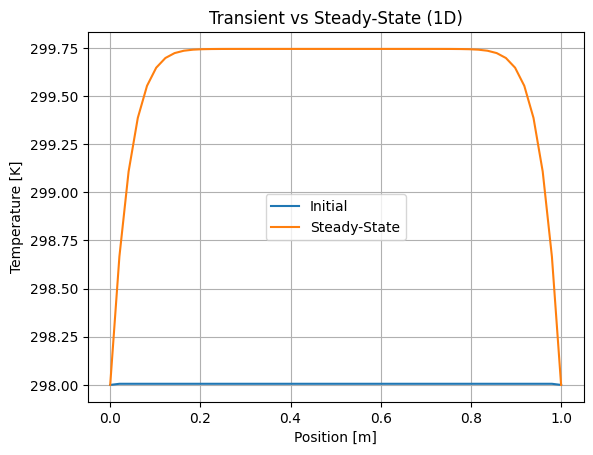

In [5]:
plt.figure()
plt.plot(x, T_all_1d[0], label="Initial")
plt.plot(x, T_all_1d[-1], label="Steady-State")
plt.legend(); plt.grid(); plt.title("Transient vs Steady-State (1D)")
plt.xlabel("Position [m]"); plt.ylabel("Temperature [K]")
plt.savefig("1d_steady_vs_transient.png", dpi=300)
plt.show()

### 🧮 SECTION 5: 2D SIMULATION

In [6]:
def simulate_plate_2d(p=params):
    dx = p["L"] / (p["nx"] - 1)
    dy = p["W"] / (p["ny"] - 1)
    alpha = p["k"] / (p["rho"] * p["cp"])
    T = np.ones((p["ny"], p["nx"])) * p["T_init"]
    T_record = []

    q_gen = p["G_t"] * 0.9 / (p["rho"] * p["cp"] * p["t"])

    for _ in range(p["nt"]):
        Tn = T.copy()
        for i in range(1, p["ny"] - 1):
            for j in range(1, p["nx"] - 1):
                d2Tdx2 = (Tn[i, j+1] - 2*Tn[i, j] + Tn[i, j-1]) / dx**2
                d2Tdy2 = (Tn[i+1, j] - 2*Tn[i, j] + Tn[i-1, j]) / dy**2
                convection = p["h"] * (Tn[i, j] - p["T_ambient"]) / (p["rho"] * p["cp"] * p["t"])
                radiation = p["epsilon"] * sigma * (Tn[i, j]**4 - p["T_ambient"]**4) / (p["rho"] * p["cp"] * p["t"])
                T[i, j] = Tn[i, j] + p["dt"] * (alpha * (d2Tdx2 + d2Tdy2) - convection - radiation + q_gen)

        T_record.append(T.copy())

    return np.linspace(0, p["L"], p["nx"]), np.linspace(0, p["W"], p["ny"]), np.array(T_record)

x2d, y2d, T_all_2d = simulate_plate_2d()

### 🌀 SECTION 6: 2D ANIMATION

In [7]:
fig2d, ax2d = plt.subplots()
im = ax2d.imshow(T_all_2d[0], cmap='hot', origin='lower', extent=[0, params["L"], 0, params["W"]])
ax2d.set_title("2D Plate Temperature"); plt.colorbar(im)

def animate2d(i):
    im.set_data(T_all_2d[i])
    ax2d.set_title(f"Step {i}")
    return [im]

ani2d = animation.FuncAnimation(fig2d, animate2d, frames=len(T_all_2d), interval=40, blit=True)
HTML(ani2d.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### 🖼️ SECTION 7: EXPORT 2D PLOT

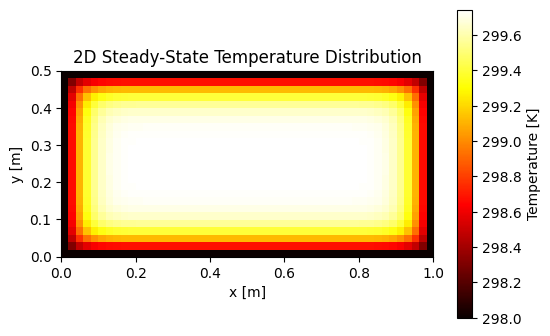

In [8]:
plt.figure(figsize=(6, 4))
plt.imshow(T_all_2d[-1], cmap='hot', origin='lower', extent=[0, params["L"], 0, params["W"]])
plt.colorbar(label='Temperature [K]')
plt.title("2D Steady-State Temperature Distribution")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.savefig("2d_steady_state.png", dpi=300)
plt.show()